[1, 2, 4, 5, 6, 9, 12, 15, 17, 20, 25, 26]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
/vol/hmi/projects/sebastian/DISFA
(48, 48)


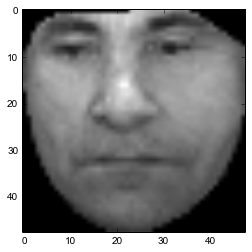

In [1]:
"""
Lets try and load the DISFA data
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from scipy import ndimage
import scipy

def prefix(i,zeros):
    s = str(i)
    while(len(s) < zeros):
        s = '0' + s
    return s

def get_face(i,subject,warped=True,path='/home/luka/v/hmi/projects/sebastian/DISFA',resize=None):
    if warped:
        s = 'SN' + prefix(subject,3)
        s = os.path.join(s,s + '_warp_frame' + prefix(i,4) + '.png')
        s = os.path.join('Videos_warped',s)
        data = ndimage.imread(os.path.join(path,s))
        if resize != None:
            data = scipy.misc.imresize(data,resize)
        return data
    
def get_subject_names(path='/home/luka/v/hmi/projects/sebastian/DISFA'):
    subjects = []
    for i in xrange(1000):
        s = os.path.join(path,'Videos/SN'+prefix(i,3))
        if os.path.isdir(s):
            subjects.append(i)
    return subjects

def get_au_names(path='/home/luka/v/hmi/projects/sebastian/DISFA'):
    aus = []
    for i in xrange(1000):
        s = os.path.join(path,'Labels/AU'+str(i))
        if os.path.isdir(s):
            aus.append(i)
    return aus
    
%matplotlib inline
path = '/vol/hmi/projects/sebastian/DISFA'

subjects = get_subject_names(path=path)
aus = get_au_names(path=path)
print aus
print subjects

print path
data = get_face(3000,8,resize=[48,48],path=path)
print data.shape
plt.figure()
plt.imshow(data,cmap='gray')
plt.show()

In [2]:
"""
For labels I want nice vectors for each face
"""

'\nFor labels I want nice vectors for each face\n'

In [3]:
def get_au(au,subject,path='/home/luka/v/hmi/projects/sebastian/DISFA'):
    s = os.path.join('Labels','AU'+str(au))
    name = 'SN'+prefix(subject,3)+'_labels_AU'+str(au)+'.mat'
    s = os.path.join(s,name)
    s = os.path.join(path,s)
    f = h5py.File(s,'r')
    return f['labels'][()][0]

au_combined = []
for i in xrange(26):
    if i in aus:
        au_combined.append(get_au(au=i,subject=4,path=path))
    else:
        au_combined.append(np.zeros(4845))
        
subject_data = []
for i in range(1,4846):
    print i,
    subject_data.append(get_face(i,8,resize=[48,48],path=path))
    
Labels = np.array(au_combined,dtype=float).transpose()
Images = np.array(subject_data)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [4]:
for i in xrange(Labels.shape[0]):
    for j in xrange(Labels.shape[1]):
        if Labels[i,j] > 0:
            Labels[i,j] = 1
        else:
            Labels[i,j] = 0
            
Images = Images.astype(float)/float(Images.max())

In [5]:
import math
import tensorflow as tf

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W,padding='SAME'):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padding)

def max_pool_axb(x,a,b):
    return tf.nn.max_pool(x, ksize=[1, a, b, 1],strides=[1, a, b, 1], padding='SAME')

x = tf.placeholder(np.float32, shape=[None, 48,48])
x_ = tf.reshape(x, [-1,48,48,1])
y_ = tf.placeholder(np.float32, shape=[None, 26])

W_conv1 = weight_variable([5, 5, 1, 64])
b_conv1 = bias_variable([64])

h_conv1 = tf.nn.relu(conv2d(x_, W_conv1,padding='VALID') + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1],padding='SAME')

print h_conv1.get_shape()
print h_pool1.get_shape()

W_conv2 = weight_variable([5, 5, 64, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2,padding="VALID") + b_conv2)

print h_conv2.get_shape()

# W_conv3 = weight_variable([4, 4, 64, 128])
# b_conv3 = bias_variable([128])

# h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3,padding="VALID") + b_conv3)

# print h_conv3.get_shape()
# print h_pool2.get_shape()

h_conv3_flat = tf.reshape(h_conv2, [-1, 207360])
print h_conv3_flat.get_shape()

W1 = tf.Variable(tf.random_uniform([207360,500], -1.0 / math.sqrt(288000), 1.0 / math.sqrt(288000)))
b1 = tf.Variable(tf.zeros([500]))

full_1 = tf.nn.relu(tf.matmul(h_conv3_flat,W1)+b1)
print full_1.get_shape()

W2 = tf.Variable(tf.random_uniform([500,26], -1.0 / math.sqrt(3072), 1.0 / math.sqrt(3072)))
b2 = tf.Variable(tf.zeros([26]))

y_conv = tf.nn.softmax(tf.matmul(full_1,W2) + b2)
print y_conv.get_shape()

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()

init = tf.initialize_all_variables()
sess.run(init)

print Images.shape
print Labels.shape
# print type(Images[0,0,0])
print sess.run(train_step, feed_dict={x: Images[:10,:,:], y_: Labels[:10,:]})
# print sess.run(loss, feed_dict={x: Images, y: Labels})

sess.close()

(?, 44, 44, 64)
(?, 22, 22, 64)
(?, 18, 18, 64)
(?, 207360)
(?, 500)
(?, 26)
(4845, 48, 48)
(4845, 26)
None


In [7]:
sess.close()